In [2]:
import os
import cv2
import random
import numpy as np
import math
import matplotlib.pyplot as plt

def generate_pologon_with_shape(h= 200, w = 640, radius_ratio = 0.9):
    
    """ Generate a random polygon. 
        Args:
            h, w: maximum width and height
            radius_ratio: range from 0-1, corresponds to the size of the polygon. 
    """
    
    irregularity=0.35
    spikiness=0.2
    
    if random.random() <0.5:
        num_points = random.randint(3, 7)
    else:
        num_points = random.randint(14, 22)

    
    # generate segment
    avg_angle = 2 * math.pi / num_points
    irregularity = irregularity * avg_angle
    angles = np.random.uniform(low=avg_angle - irregularity, high=avg_angle + irregularity, size=(num_points,))
    angles = 2 * math.pi * np.cumsum(angles / sum(angles))

    avg_radius = min(h, w) * radius_ratio
    spikiness = spikiness * avg_radius
    radiuses = np.clip(a=np.random.normal(loc=avg_radius, scale=spikiness, size=num_points), a_min=1, a_max=2 * avg_radius)

    center = np.random.uniform(low=[50, 50], high=[w - 50, h - 50], size=(2,))
    partial_seg = np.stack([radiuses * np.cos(angles), radiuses * np.sin(angles)], axis=1) + center
    partial_seg = np.clip(partial_seg, a_min=[0, 0], a_max=[w, h]).astype('int32')

    # augmentations
    roi_mask = cv2.fillPoly(img=np.zeros(shape=(h, w), dtype=np.uint8), pts=[partial_seg], color=255)
    # roi_mask = cv2.drawContours(image=roi_mask, contours=[partial_seg], contourIdx=-1, color=255, thickness=2)

    return roi_mask

def get_contour_and_bbox(binary_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)

    # Get the contour as a NumPy array with shape (n, 2)
    contour_np = max_contour.reshape(-1, 2)

    # Calculate the bounding box (x_center, y_center, width, height)
    bbox = cv2.boundingRect(max_contour)
    x_center, y_center, width, height = bbox
    x_center += width / 2
    y_center += height / 2

    return contour_np, (x_center, y_center, width, height)

def paste_filled_polygon(image1, image2):
    """ Randomly crop a polygon in image 2 then paste it into image 1

    Args:
        image1: image
        image2: background image

    """
    
    image2 = cv2.resize(image2, image1.shape[:-1][::-1])
    height, width = image1.shape[:-1]

    # Generate a polygon : 4- 7 point with shape height, witdth 
    binary_mask = generate_pologon_with_shape(height, width, random.uniform(0.14,0.22))

    # Use function make border to send it to the center
    # binary_mask = ....

    binary_mask_inv = cv2.bitwise_not(binary_mask)

    filled_polygon_mask1 = cv2.bitwise_and(image1, image1,  mask = binary_mask_inv)
    filled_polygon_mask2 = cv2.bitwise_and(image2, image2, mask = binary_mask)
    image1 = filled_polygon_mask1 + filled_polygon_mask2
    
    contour_np, (x_center, y_center, w, h) = get_contour_and_bbox(binary_mask)
    
    x_center = x_center/width
    y_center =  y_center/height
    w = w/width
    h = h/height
    
    width_column = contour_np[:, 0]
    height_column = contour_np[:, 1]
    coordinates_array = np.column_stack((width_column/width, height_column / height))
    
    return image1, np.array([0, x_center, y_center, w, h]), coordinates_array




In [3]:
img_1 = cv2.imread('/Users/giakhang/Downloads/0 (1).bmp')
img_2 = cv2.imread('/Users/giakhang/dev/teaching/huflit/deep_learning/day_01/asset/lenna_dump.png')

#mask, mask_inv, fill_m1, fill_m2, new_img = paste_filled_polygon(img_1, img_2)
new_img, box, coor_arr = paste_filled_polygon(img_1, img_2)

In [4]:
def get_new_contour_after_generate_rec(img_w, img_h, old_contours, gen_bbox):
    old_contours = old_contours.reshape(-1, 1, 2).astype(np.int32)
    img = np.zeros((img_h, img_w), dtype=np.uint8)

    mask_1 = cv2.fillPoly(img, pts=[old_contours], color=1)
    mask_2 = img.copy()
    mask_2[gen_bbox[1]:gen_bbox[3], gen_bbox[0]:gen_bbox[2]] = 1

    new_mask = np.bitwise_or(mask_1, mask_2)
    new_contours, _ = get_contour_and_bbox(new_mask)
    return new_contours

def generate_random_rectangle(contours, img):
    contours = contours.astype(np.int32)

    # Generate random box
    random_idx = random.randint(0, len(contours) - 1)
    x_center, y_center = contours[random_idx]
    bbox = (np.min(contours[:, 0]), np.min(contours[:, 1]), np.max(contours[:, 0]), np.max(contours[:, 1]))
    box_w, box_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    random_w = random.uniform(0.1, 0.4)
    random_h = random.uniform(0.1, 0.4)
    gen_rec_width, gen_rec_height = int(box_w * random_w), int(box_h * random_h)
    gen_rec_x1, gen_rec_y1 = x_center - (gen_rec_width // 2), y_center - (gen_rec_height // 2)
    gen_rec_x2, gen_rec_y2 = x_center + (gen_rec_width // 2), y_center + (gen_rec_height // 2)

    color = np.average(img[bbox[0]:bbox[2], bbox[1]:bbox[3]], axis=(0, 1))

    # Add box to image
    img_h, img_w = img.shape[:-1]
    new_img = cv2.rectangle(img, (gen_rec_x1, gen_rec_y1), (gen_rec_x2, gen_rec_y2), color, -1)
    new_contours = get_new_contour_after_generate_rec(img_w, img_h, contours, 
                                                      (gen_rec_x1, gen_rec_y1, gen_rec_x2, gen_rec_y2))

    return new_img, new_contours


In [49]:
x = [466.0, 463.0, 477.0, 477.0, 461.0, 462.0, 474.0, 807.0, 834.0, 832.0, 817.0, 809.0, 829.0, 827.0]
y = [82.0, 117.0, 150.0, 273.0, 283.0, 321.0, 330.0, 332.0, 323.0, 287.0, 274.0, 147.0, 120.0, 78.0]
contours = np.array([x, y]).T
pts = contours.reshape(-1, 1, 2).astype(np.int32)

img = np.zeros((img_1.shape), dtype=np.int32)
img = cv2.polylines(img, [pts], True, (0, 255, 0), 2)

def generate_polygon_inside_shipper(contours):
    contours = contours.astype(np.int32)
    shipper_bbox = (np.min(contours[:, 0]), np.min(contours[:, 1]), np.max(contours[:, 0]), np.max(contours[:, 1]))
    box_w, box_h = shipper_bbox[2] - shipper_bbox[0], shipper_bbox[3] - shipper_bbox[1]

    # Generate a polygon : 4- 7 point with shape height, witdth 
    polygon = generate_pologon_with_shape(box_h, box_w, random.uniform(0.14,0.22))
    polygon_region = np.where(polygon > 0)
    polygon_bbox = (np.min(polygon_region[0]), np.min(polygon_region[1]), np.max(polygon_region[0]), np.max(polygon_region[1]))
    #polygon = polygon[polygon_bbox[0]:polygon_bbox[2], polygon_bbox[1]:polygon_bbox[3]]
    
    return polygon, polygon_bbox

def get_shipper_region(contours, image):
    contours = contours.astype(np.int32)   
    shipper_bbox = (np.min(contours[:, 0]), np.min(contours[:, 1]), np.max(contours[:, 0]), np.max(contours[:, 1]))
    shipper_region = image[shipper_bbox[1]:shipper_bbox[3], shipper_bbox[0]:shipper_bbox[2]]
    
    return shipper_region

def crop_polygon_from_shipper(polygon, polygon_bbox, shipper_region):
    shipper_polygon = cv2.bitwise_and(shipper_region, shipper_region, mask=polygon)
    shipper_polygon = shipper_polygon[polygon_bbox[0]:polygon_bbox[2], polygon_bbox[1]:polygon_bbox[3]]

    return shipper_polygon

def move_shipper_polygon_to_shipper_edge(image, contours, polygon):
    contours = contours.astype(np.int32)   
    # Randomly choose the edge
    random_idx = random.randint(0, len(contours) - 1)
    x_center, y_center = contours[random_idx]

    # Get pasted region
    polygon_h, polygon_w, _ = polygon.shape
    pasted_region_x1, pasted_region_y1 = int(x_center - (polygon_w // 2)), int(y_center - (polygon_h // 2))
    pasted_region_x2, pasted_region_y2 = pasted_region_x1 + polygon_w, pasted_region_y1 + polygon_h
    pasted_region = image[pasted_region_y1:pasted_region_y2, pasted_region_x1:pasted_region_x2, :]
    
    # Append crop_shipper_polygon to shipper_region
    mask_inv = np.invert((polygon > 0)).astype(np.int8)
    pasted_region = cv2.bitwise_and(pasted_region, pasted_region, mask=mask_inv[..., 0])
    new_pasted_region = polygon + pasted_region
    new_img = image.copy()
    new_img[pasted_region_y1:pasted_region_y2, pasted_region_x1:pasted_region_x2, :] = new_pasted_region

    new_contours = find_new_contours_after_paste(image.shape[1], image.shape[0], contours,
                                                 (pasted_region_x1, pasted_region_y1, pasted_region_x2, pasted_region_y2),
                                                 polygon)
    
    new_bboxes = (np.min(new_contours[:, 0]), np.min(new_contours[:, 1]),
                  np.max(new_contours[:, 0]), np.max(new_contours[:, 1]))

    return new_img, new_contours, new_bboxes

def find_new_contours_after_paste(img_w, img_h, old_contours, pasted_bbox, polygon):
    img = np.zeros((img_h, img_w), dtype=np.uint8)
    old_contours = old_contours.reshape(-1, 1, 2).astype(np.int32)
    mask_1 = cv2.fillPoly(img.copy(), pts=[old_contours], color=1)

    mask_2 = img.copy()
    mask_2[pasted_bbox[1]:pasted_bbox[3], pasted_bbox[0]:pasted_bbox[2]] = (polygon[..., 0] > 0).astype(np.uint8)

    new_mask = np.bitwise_or(mask_1, mask_2)
    new_contours = find_contour(new_mask)

    return new_contours

def find_contour(binary_mask):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)

    # Get the contour as a NumPy array with shape (n, 2)
    contour_np = max_contour.reshape(-1, 2)
    return contour_np

def xyxy2xywh(bbox):
    x1, y1, x2, y2 = bbox
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1
    return x_center, y_center, width, height

def normalize_bbox(image_shape, bbox):
    img_height, img_width = image_shape[:2]
    x_center, y_center, width, height = bbox

    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return x_center, y_center, width, height

def normalize_contour_coordinates(image_shape, contour):
    """
    contour.shape = (num_points, 2)
    """
    height, width = image_shape[:2]
    x_norm = contour[:, 0] / width
    y_norm = contour[:, 1] / height
    contour_norm = np.stack([x_norm, y_norm], axis=1)

    return contour_norm

def normalize_bbox_and_contour_coors(image_shape, box, contour):
    """
    contour.shape = (num_points, 2)
    """

    box_norm = normalize_bbox(image_shape, box)
    contour_norm = normalize_contour_coordinates(image_shape, contour)

    return box_norm, contour_norm

def generate_polygon_inside_shipper_and_paste(contours, image):
    if image is not None:
        contours = contours.astype(np.int32)
        polygon, polygon_bbox = generate_polygon_inside_shipper(contours)
        shipper_region = get_shipper_region(contours, image)
        shipper_polygon = crop_polygon_from_shipper(polygon, polygon_bbox, shipper_region)
        new_image, new_contours, new_bboxes = move_shipper_polygon_to_shipper_edge(image, contours, shipper_polygon)
        xywh = xyxy2xywh(new_bboxes)
        xywh_norm, contours_norm = normalize_bbox_and_contour_coors(new_image.shape, xywh, new_contours)

        return new_image, contours_norm, xywh_norm
    return None

#new_img, new_contours = generate_random_rectangle(contours, img_1)

#new_img = cv2.polylines(new_img, [new_contours.reshape(-1, 1, 2)], True, (0, 255, 0), 2)

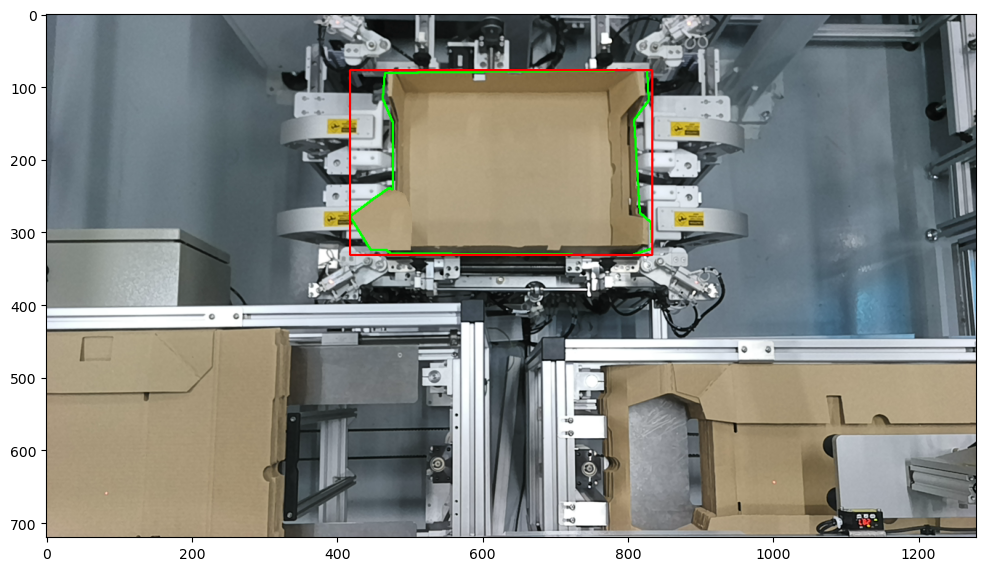

In [11]:
img_1 = cv2.imread('/Users/giakhang/Downloads/0 (1).bmp')
new_img, new_contours, new_bboxes = generate_polygon_inside_shipper_and_paste(contours, img_1)

img = cv2.polylines(new_img, [new_contours.reshape(-1, 1, 2)], True, (0, 255, 0), 2)
img = cv2.rectangle(new_img, new_bboxes[:2], new_bboxes[2:], (0, 0, 255), 2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12, 12))

plt.imshow(img)
plt.show()

In [50]:
img_1 = cv2.imread('/Users/giakhang/Downloads/0 (1).bmp')
new_img, new_contours, new_bboxes = generate_polygon_inside_shipper_and_paste(contours, img_1)

In [53]:
def draw_bbox_and_polylines(image, contours, bbox):
    # Convert normalized bbox to image coordinates
    x_center, y_center, width, height = bbox
    img_height, img_width, _ = image.shape
    x1 = int((x_center - width / 2) * img_width)
    y1 = int((y_center - height / 2) * img_height)
    x2 = int((x_center + width / 2) * img_width)
    y2 = int((y_center + height / 2) * img_height)

    x_coors = (contours[:, 0] * img_width).astype(np.int32)
    y_coors = (contours[:, 1] * img_height).astype(np.int32)
    contours = np.stack([x_coors, y_coors], axis=1)

    # Draw bounding box
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw polylines
    image = cv2.polylines(image, [contours], isClosed=True, color=(0, 0, 255), thickness=2)

    return image

(0.4875, 0.2847222222222222, 0.328125, 0.3527777777777778)


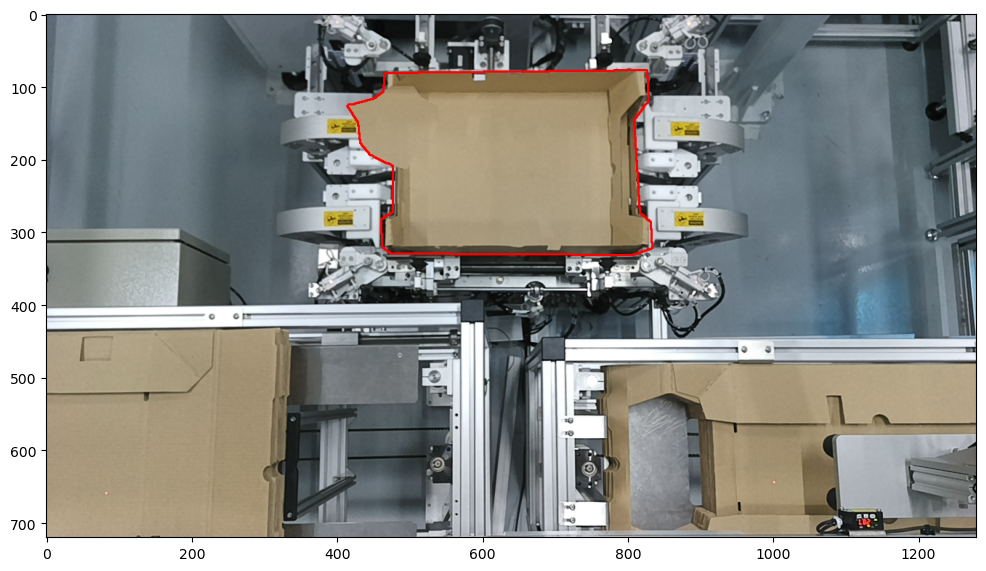

In [54]:
img = draw_bbox_and_polylines(new_img, new_contours, new_bboxes)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12, 12))

plt.imshow(img)
plt.show()